In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/fernandososter/RAG.git

Cloning into 'RAG'...
remote: Enumerating objects: 20502, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 20502 (delta 12), reused 9 (delta 1), pack-reused 20474 (from 2)
Receiving objects: 100% (20502/20502), 226.20 MiB | 20.36 MiB/s, done.
Resolving deltas: 100% (3355/3355), done.


In [3]:
!pip install -r /content/RAG/QLoRA-Youtube/requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.1 MB/s eta 0:00:00


ERROR: Could not install packages due to an OSError: No connection adapters were found for 'github.com:huggingface/trl.git'



In [4]:
import pandas as pd
import scipy as sp
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from peft import PeftModel



In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  if gpu_info.find('Tesla T4') >= 0:
    print("Success - Connected to a T4")
  else:
    print("NOT CONNECTED TO A T4")

Tue Nov 11 16:30:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
from google.colab import userdata
from huggingface_hub import login

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [7]:
df = pd.read_csv("/content/RAG/QLoRA-Youtube/dataset/youtube_video.csv")
df.head()

,video_id,title,channel_name,channel_id,view_count,like_count,comment_count,published_date,thumbnail
0,QwtOeDR-N3g,Why do Human Feet Wash up on This Beach? | Fas...,Fascinating Horror,UCFXad0mx4WxY1fXdbvtg0CQ,33955,1817,119,2025-10-03T09:15:02Z,https://i.ytimg.com/vi/QwtOeDR-N3g/hqdefault.jpg
1,K0fw1uiSGE0,"Range Rover SV (2025) - The King of the City, ...",CAR TV,UCs_gcVRMHEx5mVXfQ7icQTg,59659,1130,22,2025-10-08T09:10:46Z,https://i.ytimg.com/vi/K0fw1uiSGE0/hqdefault.jpg
2,StuKQpzfyjI,Bruce Wayne Becomes Batman - NEW Gotham City U...,Just4fun290,UCdPG86Ahrf9A8YzBnFDAaEg,8658,89,0,2025-10-04T15:00:06Z,https://i.ytimg.com/vi/StuKQpzfyjI/hqdefault.jpg
3,C91854vbs8I,How the music of Mario Kart has evolved,Thomas Game Docs,UCyy7dZhgfeMMctSoo3wDXlQ,161045,5391,239,2025-05-08T15:32:15Z,https://i.ytimg.com/vi/C91854vbs8I/hqdefault.jpg
4,1DaHVSmx160,My bulldog loves mess... you can see that )))),Enzo English Bulldog,UCkk_2IfQ52OJcCUXOrJBtnw,7620,94,24,2021-08-12T15:33:31Z,https://i.ytimg.com/vi/1DaHVSmx160/hqdefault.jpg


In [8]:
df.isna().sum()

,0
video_id,0
title,0
channel_name,0
channel_id,0
view_count,0
like_count,0
comment_count,0
published_date,0
thumbnail,0


((array([-4.44217574, -4.2475061 , -4.14176677, ...,  4.14176677,
          4.2475061 ,  4.44217574]),
  array([         0,          0,          0, ..., 2017112317, 3751827725,
         5367568626])),
 (np.float64(3366103.936077128),
  np.float64(1301435.267008845),
  np.float64(0.14567608518398456)))

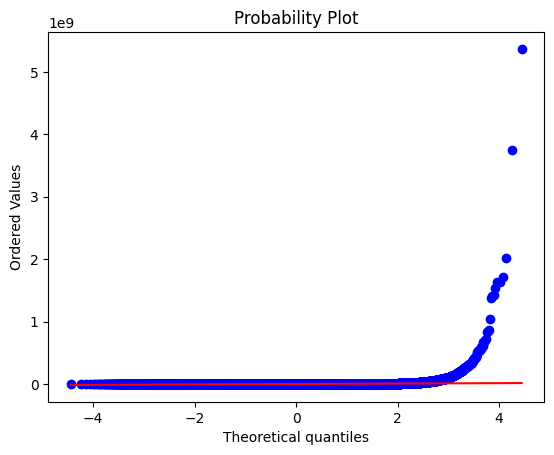

In [9]:
sp.stats.probplot(df['view_count'], dist="norm", plot=plt)

((array([-4.44217574, -4.2475061 , -4.14176677, ...,  4.14176677,
          4.2475061 ,  4.44217574]),
  array([       0,        0,        0, ..., 11828524, 12092389, 14119478])),
 (np.float64(44628.93027397453),
  np.float64(19958.19542747752),
  np.float64(0.30336283147611925)))

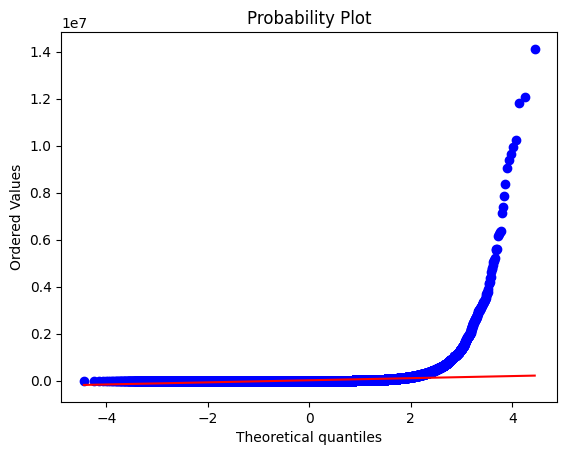

In [10]:
sp.stats.probplot(df['like_count'], dist="norm", plot=plt)

In [15]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "QLoRA-Youtube"
HF_USER = "fsoster"

QUANT_4_BIT = True

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}
RUN_NAME = "2025-11-11_13.04.39"
#PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}"
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

%matplotlib inline

In [12]:
X = df['title']
y = df['view_count']

In [13]:

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [17]:
from transformers import TrainingArguments, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from peft import PeftModel
from peft import LoraConfig
from trl import SFTTrainer

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)

peft_config = LoraConfig(r=64, lora_alpha=16, lora_dropout=0.05, task_type="CAUSAL_LM")

# Args de treino
args = TrainingArguments(
    output_dir="./sft-output",
    per_device_train_batch_size=2,
    num_train_epochs=1,
    learning_rate=2e-4,
)

# Cria o trainer SFT
trainer = SFTTrainer(
    model=model_id,
    peft_config=peft_config,
    tokenizer=tokenizer,
    train_dataset=train_data,
    formatting_func=lambda e: e["prompt"] + " " + e["response"],
    args=args,
)

trainer.train()
trainer.save_model("./sft-output")

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="cuda",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id


fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL,device_map="cuda")


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

KeyboardInterrupt: 

In [ ]:
fine_tuned_model

In [ ]:


# Args de treino
args = TrainingArguments(
    output_dir="./sft-output",
    per_device_train_batch_size=2,
    num_train_epochs=1,
    learning_rate=2e-4,
)

# Cria o trainer SFT
trainer = SFTTrainer(
    model=model_id,
    peft_config=peft_config,
    tokenizer=tokenizer,
    train_dataset=train_data,
    formatting_func=lambda e: e["prompt"] + " " + e["response"],
    args=args,
)

trainer.train()
trainer.save_model("./sft-output")

In [ ]:
set_seed(42)
inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
attention_mask = torch.ones(inputs.shape, device="cuda")
outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
response = tokenizer.decode(outputs[0])